In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/ludo/ownCloud/Programmes/julia/biomaths_julia_www"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| code-fold: true
using DifferentialEquations, DataFrames

# conditions initiales
x0 = 1.0
y0 = 1.95
etat0 = [x0, y0]

# paramètres
r = 1.0
K = 10.0 
c = 1.0
h = 2.0
b = 2.0
m = 1.0

par_rma = [r, K, c, h, b, m]

# temps d'integration 
tspan = (0.0, 55.0)
tstep = .01

# définition du modèle
function rma(u, par, t)
    r, K, c, h, b, m = par
    x = u[1]
    y = u[2]

    dx = r*x*(1-x/K) - c*x/(h+x)*y
    dy = b*x/(h+x)*y - m*y
    
    [dx, dy]
end

# problème
prob_rma = ODEProblem(rma, etat0, tspan, par_rma, saveat = tstep)
# intégration
sol_rma = solve(prob_rma, reltol = 1e-6)
# dataframe
sol_rma = DataFrame(sol_rma)
rename!(sol_rma, :timestamp => :time, :value1 => :x, :value2 => :y)

Row,time,x,y
,Float64,Float64,Float64
1,0.0,1.0,1.95
2,0.01,1.00252,1.94352
3,0.02,1.00506,1.93709
4,0.03,1.00764,1.93069
5,0.04,1.01025,1.92435
6,0.05,1.01289,1.91804
7,0.06,1.01556,1.91178
8,0.07,1.01826,1.90556
9,0.08,1.02099,1.89938


In [3]:
using CairoMakie

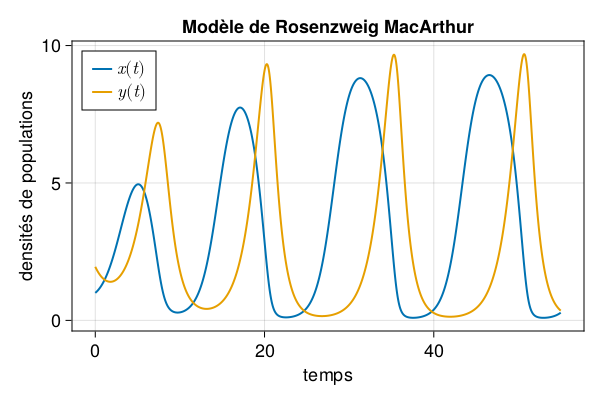

In [4]:
#| output: true
#| label: fig-dyn-rma
#| fig-cap: Ma première figure avec `Makie.jl`
# on crée la figure
fig1 = Figure(backgroundcolor = :transparent,
              resolution = (600,400),   # size
              fontsize = 18)  

# on crée un système d'axes en position [1,1] dans la figure
ax1 = Axis(fig1[1,1],
           xlabel = "temps",
           ylabel = "densités de populations",
           title = "Modèle de Rosenzweig MacArthur")

# on trace la population x contre le temps sur le système d'axe ax1
lines!(ax1, sol_rma.time, sol_rma.x,
       linewidth = 2,
       linestyle = :solid,
       label = L"x(t)")

# population y
lines!(ax1, sol_rma.time, sol_rma.y,
       linewidth = 2,
       linestyle = :solid,
       label = L"y(t)")

# légende
axislegend(position = :lt)

# on affiche la figure
fig1

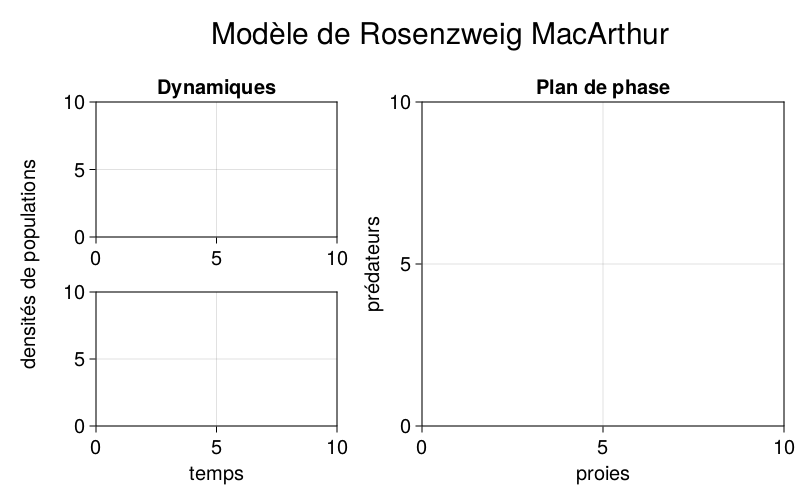

In [5]:
#| output: true
# figure
fig2 = Figure(backgroundcolor = :transparent,
              resolution = (800,500),   # size
              fontsize = 20,
              font = "CMU Serif")  

# 3 systèmes d'axes
ax21 = Axis(fig2[1,1],
            title = "Dynamiques")

ax22 = Axis(fig2[2,1],
            xlabel = "temps")

ax23 = Axis(fig2[:,2],
            xlabel = "proies",
            ylabel = "prédateurs",
            title = "Plan de phase")

# on agrandi un peu la deuxième colonne de la figure
colsize!(fig2.layout, 2, Auto(1.5))

# ajout d'un titre
supertitle = Label(fig2[0, :], "Modèle de Rosenzweig MacArthur", fontsize = 30)
# et d'un label d'axes commun à la première colonne
sideinfo = Label(fig2[1:2, 0], "densités de populations", rotation = pi/2)

# on affiche la figure
fig2

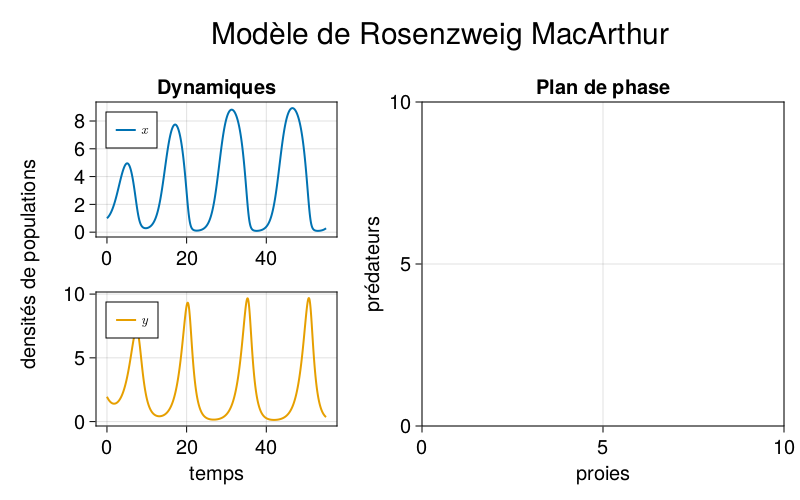

In [6]:
#| output: true
lines!(ax21, sol_rma.time, sol_rma.x,
       color = Cycled(1),  # pick color 1 in the colorcycle
       linewidth = 2,
       linestyle = :solid,
       label = L"x")
axislegend(ax21, position = :lt, labelsize = 14)

lines!(ax22, sol_rma.time, sol_rma.y,
       color = Cycled(2),
       linewidth = 2,
       linestyle = :solid,
       label = L"y")
axislegend(ax22, position = :lt, labelsize = 14)


fig2

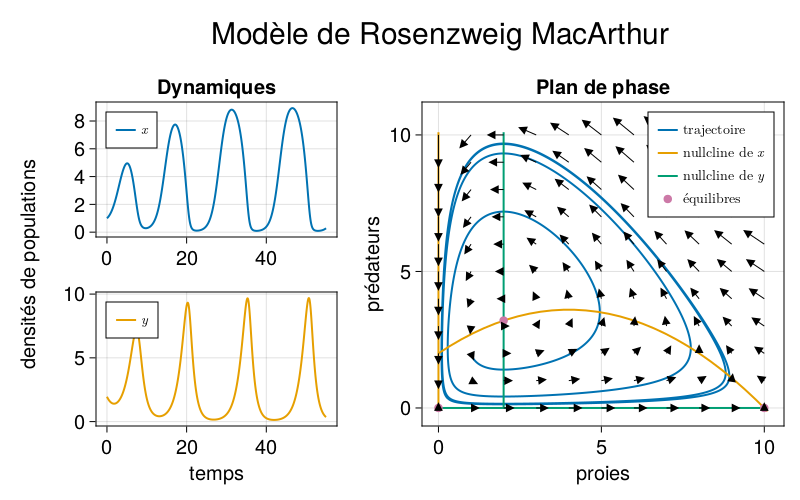

In [7]:
#| output: true
# trajectoires
lines!(ax23, sol_rma.x, sol_rma.y,
       color = Cycled(1),
       linewidth = 2,
       linestyle = :solid,
       label = L"trajectoire $$")

# calcul des isoclines nulles
x = LinRange(0.0, K+.1, 30)
y = x

# isoclines nulles de xdot
null_x_x = ones(length(y)).*0        # x = 0 isocline nulle de xdot
null_x_y = r./c.*(h.+x).*(1 .-x./K)  # y = f(x) isocline nulle de xdot

# isoclines nulles de ydot
null_y_y = ones(length(y)).*0           # y = 0 isocline nulle de ydot
null_y_x = ones(length(y)).*m.*h./(b-m) # x = mh/(b-m) isocline nulle de ydot

# tracé des isoclines nulle de x
lines!(ax23, null_x_x, y,
       color = Cycled(2),
       linewidth = 2,
       linestyle = :solid)

lines!(ax23, x, null_x_y, 
       color = Cycled(2),
       linewidth = 2,
       linestyle = :solid,
       label = L"nullcline de $x$")

# tracé des isoclines nulle de y
lines!(ax23, x, null_y_y, 
       color = Cycled(3),
       linewidth = 2,
       linestyle = :solid)
lines!(ax23, null_y_x, y,
       color = Cycled(3),
       linewidth = 2,
       linestyle = :solid,
       label = L"nullcline de $y$")

# tracé des équilibres
scatter!(ax23, 0, 0,
         color = Cycled(4),
         label = L"équilibres$$")
scatter!(ax23, K, 0,
         color = Cycled(4))

eq_coex = [m*h/(b-m), r/c*(h+m*h/(b-m))*(1-m*h/(b-m)/K)]

scatter!(ax23, eq_coex[1], eq_coex[2],
         color = Cycled(4))

axislegend(ax23, position = :rt, labelsize = 14)

# champs de vecteur
scale = 10
der_x(x, y) = rma([x y], par_rma, 0)[1]/scale
der_y(x, y) = rma([x y], par_rma, 0)[2]/scale

# on définit un ensemble de valeur de x et y formant une grille 
xrange = range(0., 10, length=11)  # note ' : on va broadcaster pour créer la grille via der_x.() et der_y.()
yrange = range(0. ,10, length=11)

derx= [der_x(x, y) for x in xrange, y in yrange]
dery= [der_y(x, y) for x in xrange, y in yrange]

arrows!(ax23, xrange, yrange, derx, dery)

fig2